# Word Embeddings

Many of the improvements and extensions we have in mind for the next stage of *EarlyPrint* involve word embeddings. Using popular algorithms like Word2Vec, which we'll use in this tutorial, word embeddings create numeric representations for each word in a text corpus based on how frequently that word co-occurs alongside other words. Using word embeddings, it's possible to compute the semantic relationship among words in a corpus, to find **how words are related**.

Word embeddings have lots of different downstream uses for machine learning and text analysis tasks; for instance, they're an important building block for state-of-the-art natural language processing models. In this tutorial we'll focus on the basics: training a Word2Vec model and using the model to identify and visualize similar words.

You can decide how deep you'd like to go into the weeds of the ways Word2Vec actually produces its similarities. For a first introduction, I recommend [Jay Alammar's *The Illustrated Word2Vec*](https://jalammar.github.io/illustrated-word2vec/), which includes lots of helpful visualizations as it explains the basics. In this tutorial, we'll focus on training Word2Vec in Python and interpreting the results, rather than reviewing the underlying concepts.

Let's begin by importing the necessarily libraries:

In [1]:
from lxml import etree
from gensim.models import Word2Vec
import glob, csv
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Select a Corpus and Tokenize Sentences

Word2Vec creates vectors based on which words are near one another. We'll train our model on lists of words from a selected corpus, and we'll use the same corpus we've been using all along: the *EarlyPrint* texts published in 1666.

We're using the [Gensim](https://radimrehurek.com/gensim/models/word2vec.html) library to create our Word2Vec model. Gensim accepts several different types of input, but we'll focus on giving it lists of word tokens. You could create a list of all the tokens in a text and pass them directly to Gensim, but Gensim prefers that you give it each sentence separately. This is because sentence boundaries often contain information about word relationships: the last word of a given sentence and the first word of the next one don't have the same relationship as two words in the same sentence.

Below we create a function for finding the lemmas in every sentence of our texts, which then collects those sentences as individual lists. For more detail on how this code works, refer to [our XML tutorial](https://earlyprint.org/jupyterbook/ep_xml.html#step-4-lines-stanzas-and-sentences).

In [2]:
def get_sentences(filename):
    parser = etree.XMLParser(collect_ids=False)
    tree = etree.parse(filename, parser)
    xml = tree.getroot()
    new_sentence = [] # An empty list for the first sentence
    # Loop through every tag
    for word in xml.iter('{*}w'):
        previous = word.getprevious()
        if previous != None and previous.get('unit', previous) == 'sentence':
            all_sentences.append(new_sentence)
            new_sentence = []
        new_sentence.append(word.get('lemma', word.text).lower())

In [3]:
nsmap={'tei': 'http://www.tei-c.org/ns/1.0'}
files = glob.glob('1666_texts_full/*.xml')
all_sentences = []
for f in files:
    get_sentences(f)

## Train a Model and Find Similar Words

Now that we have a list of all the lemmas in all the sentences in our texts, we're ready to train our Word2Vec model. This can be done with the simple one-line command below.

The parameter `min_count` refers to the minimum number of times a word must appear in the corpus in order to be part of the model. For the sake of speed, I'm eliminating all words that appear less than 2 times. (And since the eliminated words appear only once, the resulting vectors wouldn't be very reliable anyway: not enough examples of adjacent words.)

The parameter `window` refers to the "sliding window" that Word2Vec pulls across a sentence to determine if words are near each other. The default window is 5 words. In general, Word2Vec gives better results in a very large corpus, when there are lots of instances of every word. For our *EarlyPrint* applications of Word2Vec, we'll train the model on the full corpus. But for this sample one-year corpus, let's shrink the window to just 4 words, which will generate more windows across our smaller corpus.

Once we've selected parameters we can train our Word2Vec model.

In [4]:
word2vec = Word2Vec(all_sentences, min_count=2, window=4)

Word2Vec outputs a model with a `wv` object that contains lots of information about the word embeddings. For example, every single word in the corpus is stored in the `vocab` attribute:

In [5]:
print(list(word2vec.wv.vocab)[:50])

['the', 'dutch', 'gazette', 'or', 'sheet', 'of', 'wildfire', 'that', 'fire', 'fleet', 'i', 'will', 'tell', 'you', 'not', 'aetna', 'flame', 'nor', 'troy', 'long', 'ago', 'have', 'fill', 'world', 'with', 'noise', 'romance', 'history', 'do', 'age', 'before', 'who', 'obsequy', 'be', 'sing', 'by', 'laureate', 'pen', 'which', 'story', 'can', 'parallel', 'rupert', 'duke', 'albemarle', 'and', 'rest', 'send', 'those', 'to']


Using the `wv` object, it's simple to retrieve the words most similar to a particular word of your choice. Looking at the first 50 words in the corpus above, we'll choose a word with special resonance for 1666, the year of the Great Fire of London: "flame." Let's find the words most similar to the word "flame," where similarity refers to the likelihood that the word would appear in contexts measurably like the ones in which "flame" appears.

In [6]:
print(word2vec.wv.most_similar("flame"))

[('fire', 0.8489426970481873), ('cloud', 0.842170238494873), ('coal', 0.8359401226043701), ('smoke', 0.8104960918426514), ('fiery', 0.7995160818099976), ('lamp', 0.7885575294494629), ('flood', 0.7738324999809265), ('burn', 0.773443341255188), ('valley', 0.758803129196167), ('shower', 0.7462021112442017)]


The `most_similar()` function gives the top ten most similar words to the word you selected. The similar words to "flame"—"fire," "smoke", "burn"—make a lot of sense.

The values given with each word are its cosine similarity to the source word. (See our [Similarity tutorial](https://earlyprint.org/jupyterbook/similarity.html) for more about this.)

If you had a list of words you were particularly interested in, perhaps organized around a theme, you could easily look at the most similar words to each one and begin to populate the semantic field of the topic that interests you.

## Accessing and Visualizing Vectors

But we can do more with word embeddings than simply find similar words. Word2Vec creates a vector, a string of numerical values for each word, that we can access with the `wv` object.

In [7]:
print(word2vec.wv["flame"])

[ 0.5179528   0.5570465   1.2318884   0.43771747 -0.01617345  0.97757787
 -0.7484764  -0.00724528  1.5031803   0.5369354   0.30949283  0.7545617
  0.84283984  1.0048558  -0.84035486 -1.7151331  -0.47222072  0.09903593
  0.14043379  0.32874274 -0.6886271  -0.30410767  0.977618    1.2272265
 -0.7384447   0.44142935 -0.90228194 -0.20985112  0.01848513  1.8952253
 -0.21333317 -1.1806738   0.04373931  0.44352213  0.05902958  0.34504023
 -1.1262454  -0.75915426 -0.41524896 -1.7185836   0.26474038  0.07632465
  0.6608737   0.03441384 -0.05850032  0.6591872   0.5648993   0.7218732
 -0.43014666  0.35080278  0.4806738   1.1421118   0.5904824  -0.15326199
 -0.61639357  1.212343    0.09755696 -1.070593    0.00394901 -0.93870425
  0.6188808  -0.03228853  0.7208121  -0.4836805   0.40608627  0.4845977
  0.02519704  0.9874886  -1.111604   -0.951121    0.83848053  0.7699397
 -0.14420675 -0.09712131 -0.1438172  -0.18786599  0.45889226 -0.43260136
  0.92145246 -0.04174797  0.19176058  0.88136625 -0.80377

Each word in the text has a vector of the same length of 100 features, or dimensions, though the value of each feature will be different for every word. Using these 100-dimension vectors, we can recreate some of the illustrations from Alammar's [The Illustrated Word2Vec](https://jalammar.github.io/illustrated-word2vec/).

Let's start with "flame" and three similar words: "cloud," "fire," and "smoke." We can put the vectors of each of these words into a `pandas` DataFrame and then visualize them as a heatmap. 

*n.b. For this step and the next one, we are using [L2-normalized](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm) vectors accessed through the `vectors_norm` attribute. This simply gives us comparable numbers regardless of magnitude, or how frequently a single word appears.*

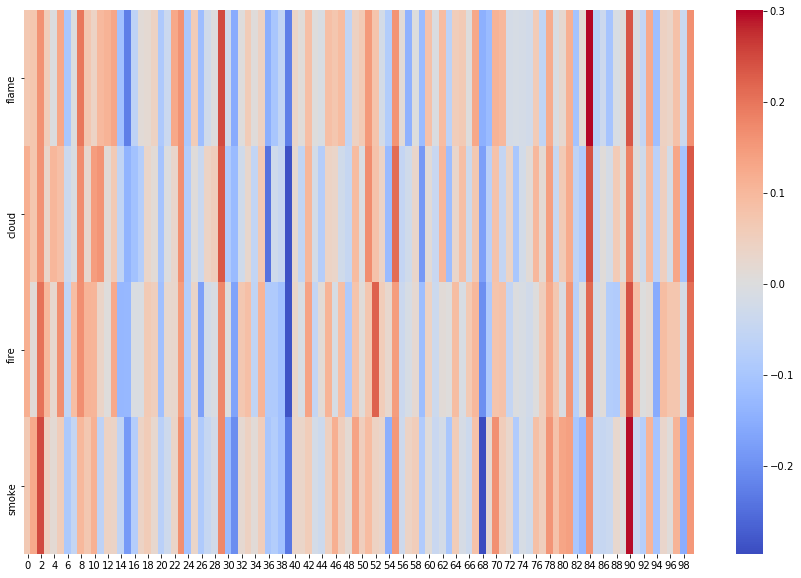

In [8]:
wordlist = ["flame", "cloud", "fire", "smoke"] # The words we've selected
indices = [word2vec.wv.index2entity.index(w) for w in wordlist] # The numerical indices of those words

df = pd.DataFrame(word2vec.wv.vectors_norm[indices], index=wordlist)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df, cmap='coolwarm')

Like in Alammar's illustrations for "king," "man," and "woman," it's easy to see why these words have high similarity scores. Parts of the vectors for each word have high (red) values and low (blue) values, and these roughly matchup from word to word.

We could visualize every single word this way, but the resulting chart would be very hard to read. Instead, let's try other visualization methods.

## Visualize Word Similarity

By default Word2Vec reduces a word to a vector of 100 features, or 100 dimensions. We can't visualize a 100-dimensional space: the best we can do is two or three. To go from 100 dimensions to just 2, we need a method for feature reduction. 

We'll use one of the most common feature reduction methods: Principal Component Analysis. PCA reduces a high-dimensional space into just a few "principal components" that attempt to account for most of the variance in the data. In many applications, such as when [calculating similarity](https://earlyprint.org/jupyterbook/similarity.html), it's best to work in the higher dimensional space directly. But PCA is a very useful tool for visualization: just remember that you're looking at a reduced representation of the data rather than the  original data.

Let's import PCA from `sklearn`:

In [9]:
from sklearn.decomposition import PCA

We'll initialize PCA with just 2 principal components, since we want to graph in 2 dimensions. We want to give PCA the vectors for every word in our corpus: remember that we can access a complete list of words using `wv.vocab`.

Below we'll run PCA and put the results in a DataFrame:

In [10]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(word2vec.wv.vectors_norm)
pca_df = pd.DataFrame(pca_results, index=word2vec.wv.vocab, columns=["pc1","pc2"])
pca_df

,pc1,pc2
the,1.308251,-0.103702
dutch,1.280252,0.091730
gazette,1.279544,-0.098819
or,1.295807,-0.092179
sheet,1.274227,0.015613
...,...,...
whittall,-0.170072,-0.283742
noyes,-0.108505,-0.109053
grone,0.190941,-0.193839
westley,-0.101291,-0.322777


Now that we have a DataFrame with just 2 dimensions, "pc1" and "pc2," we can create a scatterplot of every word, where our principal components are the x and y axes.

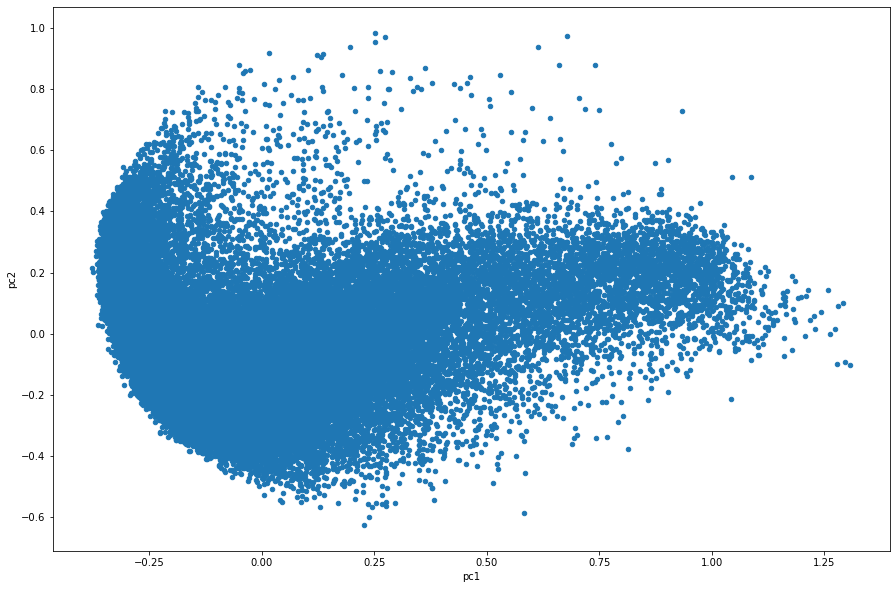

In [11]:
pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10))

The graph above gives us a general sense of where each word sits in relation to all the others, but it's not very informative as a mass of blue dots.

Let's use this graph as a base, but get rid of all the dots and just show the labels for the four words we care about.

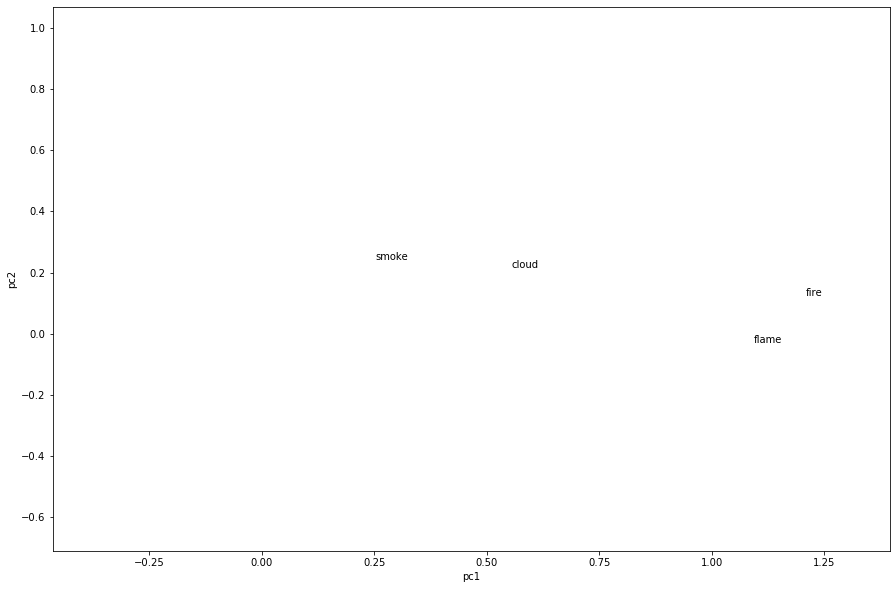

In [12]:
ax = pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10),alpha=0)
for txt in pca_df.index:
    if txt in ["flame", "cloud", "fire", "smoke"]:
        x = pca_df.pc1.loc[txt]
        y = pca_df.pc2.loc[txt]
        ax.annotate(txt, (x,y))
plt.show()

This is much better. We can see how the words are positioned relative to one another. Though we might have expected to seem them next to each other, remember that PCA is only showing us a reduced representation of our high-dimensional data. Still, we can see that "smoke" and "cloud" are closer to each other than "flame" and "fire." And all four words are almost in a horizontal line across the graph, suggesting they're quite similar according to principal component 2 (the y-axis), but perhaps less similar according to PC1 (the x-axis). Finally, by comparing the last graph to this one, we can also see where these words fit in areas of semantic density (lots of similar words) versus sparseness (words with more distinct meanings).

As text similarity increased our sense of text-level relationships in the Similarity tutorial, Word2Vec gives us a clearer (but not complete) sense of word-level relationships. Stacked with other methods, Word2Vec can be used to explore themes and subjects, to help computers and human readers make sense of semantic distinctions, and to drive complex language-based machine learning algorithms.